C:\Users\admin1\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


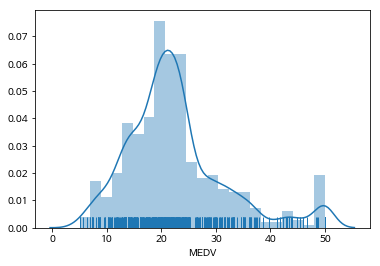

0

In [150]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale,robust_scale,minmax_scale # 데이터 scale
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
ds_house = pd.read_csv("./Practice data/BOSTON_HOUSING.CSV",engine="python")
ds_house
sns.distplot(ds_house["MEDV"],rug = True)
plt.show()

len(ds_house[ds_house["MEDV"]==41])

In [151]:
ds_house.isnull().sum()

MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

# 분석에 필요한 변수 설정

In [152]:
ds_house = ds_house[ds_house["MEDV"]<41]

ds_house_y = ds_house["MEDV"]
ds_house_x = ds_house.drop("MEDV", axis =1, inplace = False)


ds_house_y = ds_house_y.reset_index(drop = True)
ds_house_x = ds_house_x.reset_index(drop = True)


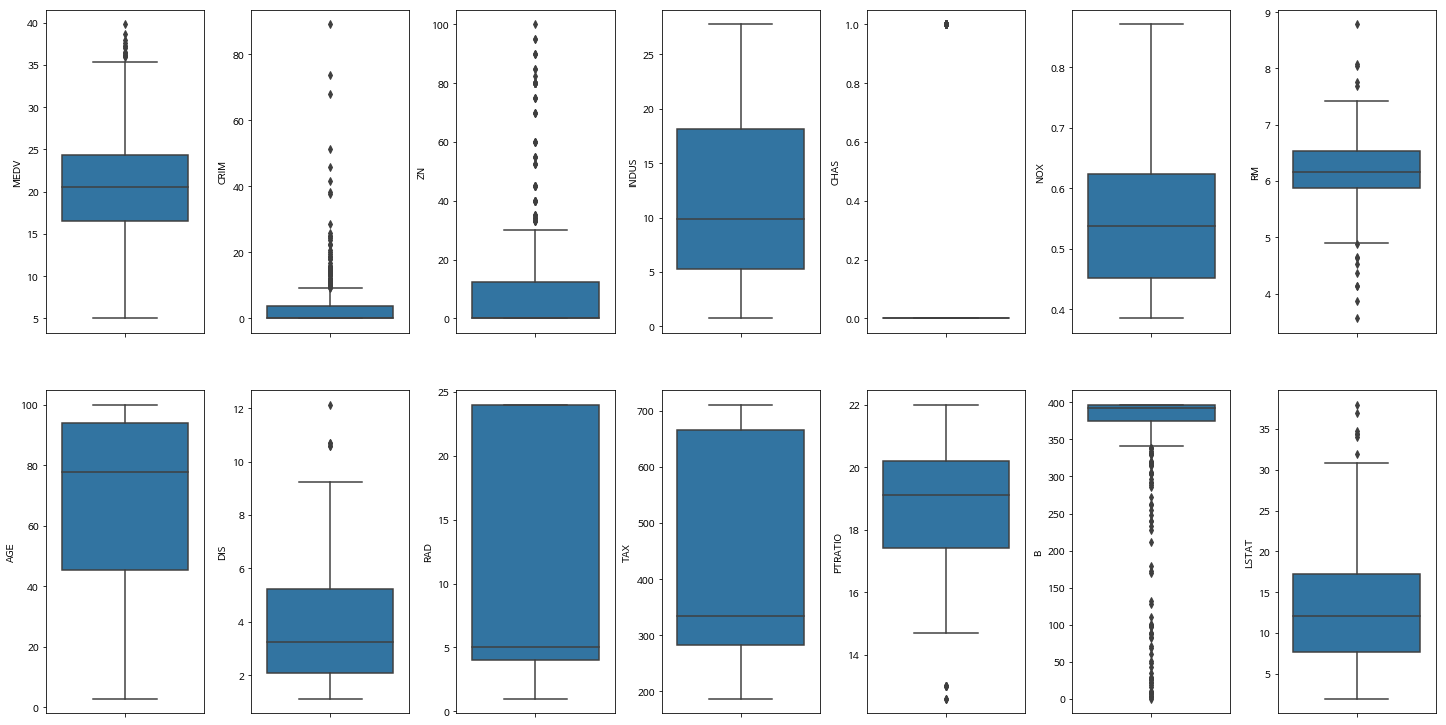

In [153]:
# 이상치 확인
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20,10))
index = 0
axs = axs.flatten()
for k,v in ds_house.items():
    sns.boxplot(y=k, data=ds_house, ax=axs[index])
    index+=1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
# 이상치라고 판단해서 데이터를 빼버리면 데이터가 없기때문에 그냥 했다.
# 정보가 없어서 제거하지 않았다.

# 변수 간의 경향성 파악 - 정규화 하지 않은 Boxplot

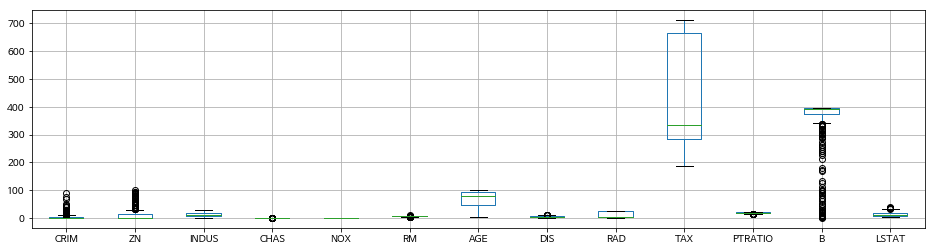

In [154]:
ds_house_x.boxplot(figsize=(16,4))

# 변수 간의 경향성 파악 - 정규화 Boxplot

In [155]:
'''
ds_house_x_scale = scale(ds_house_x)
ds_house_x_scale = pd.DataFrame(ds_house_x_scale,columns = ds_house_x.columns)
ds_house_x_scale["CHAS"] = ds_house_x["CHAS"]
ds_house_x_scale.boxplot(figsize=(16,4))
'''

'\nds_house_x_scale = scale(ds_house_x)\nds_house_x_scale = pd.DataFrame(ds_house_x_scale,columns = ds_house_x.columns)\nds_house_x_scale["CHAS"] = ds_house_x["CHAS"]\nds_house_x_scale.boxplot(figsize=(16,4))\n'

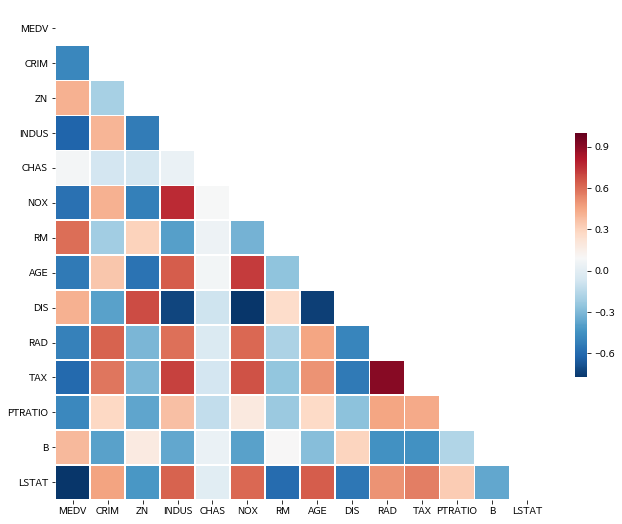

In [156]:
#HeatMap으로 볼 때 더 직관적이다.
#plt.title('variable correlation')
columnNames =list(ds_house.head(0))
corr = ds_house[columnNames[0:]].corr(method='pearson')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(ds_house.corr(), mask=mask, cmap="RdBu_r", vmax=1, center=0.1,square=True, linewidths=.5, cbar_kws={"shrink": .5})

# 회귀분석

In [157]:
ds_house_x_const = sm.add_constant(ds_house_x)
reg_multi_model = sm.OLS(ds_house_y,ds_house_x_const)
reg_multi_results = reg_multi_model.fit()
print(reg_multi_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     119.1
Date:                Thu, 31 Jan 2019   Prob (F-statistic):          3.90e-138
Time:                        23:40:18   Log-Likelihood:                -1234.3
No. Observations:                 475   AIC:                             2497.
Df Residuals:                     461   BIC:                             2555.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.2701      3.718     10.293      0.0

# VIF

In [158]:
ds_vif = pd.DataFrame()
ds_vif["variable"] = ds_house_x_const.columns
ds_vif["VIF"] = [variance_inflation_factor(ds_house_x_const.values,i) for i in range(ds_house_x_const.shape[1])]

ds_vif.sort_values("VIF",inplace =True)
ds_vif.round(3)

,variable,VIF
4,CHAS,1.068
12,B,1.347
11,PTRATIO,1.636
6,RM,1.777
1,CRIM,1.790
2,ZN,2.327
13,LSTAT,3.039
7,AGE,3.132
3,INDUS,3.958
8,DIS,4.076


# TAX 변수 제거

In [159]:
'''
ds_house_x_const = ds_house_x.drop(["TAX"], axis =1, inplace = False)
ds_house_x_const = sm.add_constant(ds_house_x_const)
reg_multi_model = sm.OLS(ds_house_y,ds_house_x_const)
reg_multi_results = reg_multi_model.fit()
print(reg_multi_results.summary())
'''

'\nds_house_x_const = ds_house_x.drop(["TAX"], axis =1, inplace = False)\nds_house_x_const = sm.add_constant(ds_house_x_const)\nreg_multi_model = sm.OLS(ds_house_y,ds_house_x_const)\nreg_multi_results = reg_multi_model.fit()\nprint(reg_multi_results.summary())\n'

# 제거후 VIF

In [160]:
ds_vif = pd.DataFrame()
ds_vif["variable"] = ds_house_x_const.columns
ds_vif["VIF"] = [variance_inflation_factor(ds_house_x_const.values,i) for i in range(ds_house_x_const.shape[1])]

ds_vif.sort_values("VIF",inplace =True)
ds_vif.round(3)

,variable,VIF
4,CHAS,1.068
12,B,1.347
11,PTRATIO,1.636
6,RM,1.777
1,CRIM,1.790
2,ZN,2.327
13,LSTAT,3.039
7,AGE,3.132
3,INDUS,3.958
8,DIS,4.076


# 스케일 정리

In [161]:
ds_house_x_scale= scale(ds_house_x)
ds_house_x_scale= pd.DataFrame(ds_house_x_scale,columns = ds_house_x.columns)
ds_house_x_scale["CHAS"] = ds_house_x["CHAS"]

C:\Users\admin1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


# 스케일 데이터로 회귀분석

In [162]:
ds_house_x_scale_const = sm.add_constant(ds_house_x_scale)
reg_multi_model = sm.OLS(ds_house_y,ds_house_x_scale_const)
reg_multi_results = reg_multi_model.fit()
print(reg_multi_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     119.1
Date:                Thu, 31 Jan 2019   Prob (F-statistic):          3.90e-138
Time:                        23:40:19   Log-Likelihood:                -1234.3
No. Observations:                 475   AIC:                             2497.
Df Residuals:                     461   BIC:                             2555.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.8573      0.157    133.266      0.0

# 스케일 데이터로 VIF

In [163]:
ds_vif = pd.DataFrame()
ds_vif["variable"] = ds_house_x_scale_const.columns
ds_vif["VIF"] = [variance_inflation_factor(ds_house_x_scale_const.values,i) for i in range(ds_house_x_scale_const.shape[1])]

ds_vif.sort_values("VIF",inplace =True)
ds_vif.round(3)

,variable,VIF
0,const,1.067
4,CHAS,1.068
12,B,1.347
11,PTRATIO,1.636
6,RM,1.777
1,CRIM,1.790
2,ZN,2.327
13,LSTAT,3.039
7,AGE,3.132
3,INDUS,3.958


# TAX 변수 제거

In [164]:
ds_house_x_scale_const = ds_house_x_scale_const.drop(["TAX"], axis =1, inplace = False)

reg_multi_model = sm.OLS(ds_house_y,ds_house_x_scale_const)
reg_multi_results = reg_multi_model.fit()
print(reg_multi_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     121.7
Date:                Thu, 31 Jan 2019   Prob (F-statistic):          1.32e-134
Time:                        23:40:21   Log-Likelihood:                -1245.3
No. Observations:                 475   AIC:                             2517.
Df Residuals:                     462   BIC:                             2571.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.8323      0.160    130.291      0.0

In [165]:
ds_vif = pd.DataFrame()
ds_vif["variable"] = ds_house_x_const.columns
ds_vif["VIF"] = [variance_inflation_factor(ds_house_x_const.values,i) for i in range(ds_house_x_const.shape[1])]

ds_vif.sort_values("VIF",inplace =True)
ds_vif.round(3)

,variable,VIF
4,CHAS,1.068
12,B,1.347
11,PTRATIO,1.636
6,RM,1.777
1,CRIM,1.790
2,ZN,2.327
13,LSTAT,3.039
7,AGE,3.132
3,INDUS,3.958
8,DIS,4.076


# 후진 제거법을 이용한 회귀분석

In [166]:
model = LinearRegression()
rfe= RFE(estimator = model,n_features_to_select = 5).fit(ds_house_x_scale,ds_house_y)
selected_cols = ds_house_x_scale.columns[rfe.support_]
removed_cosl = ds_house_x_scale.columns[~rfe.support_]
print("Selected Variables : {}".format(selected_cols))
print("Removed Variables : {}".format(removed_cosl))

Selected Variables : Index(['NOX', 'RAD', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')
Removed Variables : Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'RM', 'AGE', 'DIS', 'B'], dtype='object')


In [167]:
ds_house_x_scale_rfe= sm.add_constant(ds_house_x_const[selected_cols])
reg_multi_rfe_model = sm.OLS(ds_house_y, ds_house_x_scale_rfe)
reg_multi_rfe_results = reg_multi_rfe_model.fit()
print(reg_multi_rfe_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     210.7
Date:                Thu, 31 Jan 2019   Prob (F-statistic):          1.85e-117
Time:                        23:40:22   Log-Likelihood:                -1304.3
No. Observations:                 475   AIC:                             2621.
Df Residuals:                     469   BIC:                             2646.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.5605      2.106     24.002      0.0

In [168]:
ds_vif = pd.DataFrame()
ds_vif["variable"] = ds_house_x_scale_rfe.columns
ds_vif["VIF"] = [variance_inflation_factor(ds_house_x_scale_rfe.values,i) for i in range(ds_house_x_scale_rfe.shape[1])]

ds_vif.sort_values("VIF",inplace =True)
ds_vif.round(3)

,variable,VIF
4,PTRATIO,1.353
5,LSTAT,1.778
1,NOX,2.252
2,RAD,5.980
3,TAX,6.808
0,const,146.475


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002130DC8C9B0>,
      dtype=object)

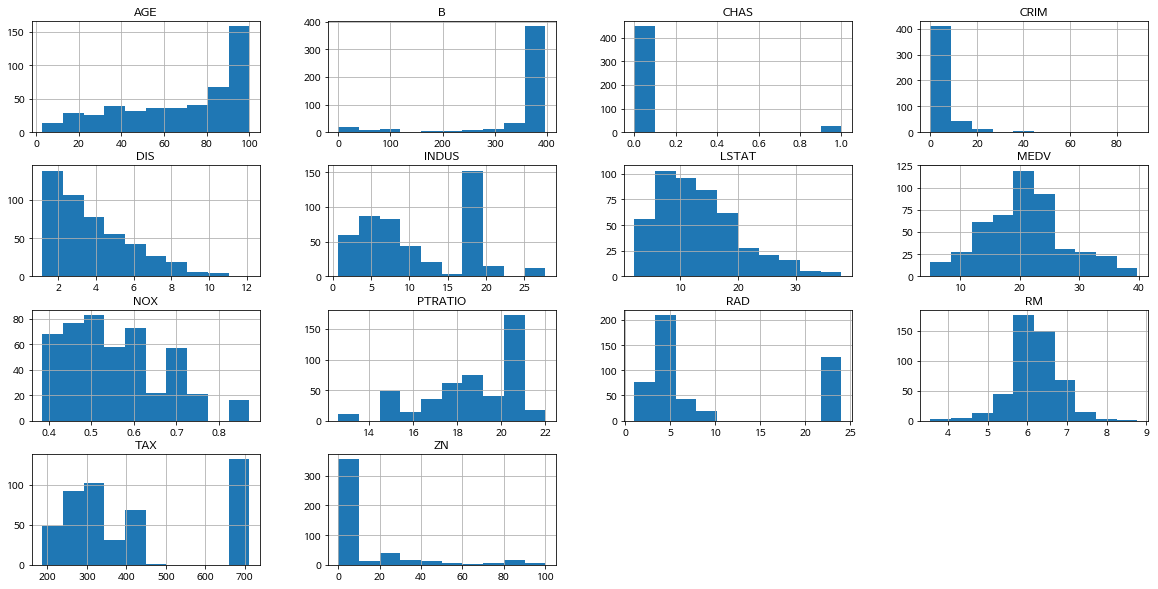

In [169]:
ds_house.hist(figsize=(20,10))

C:\Users\admin1\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


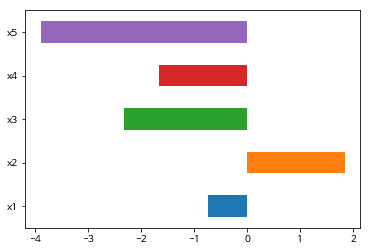

In [170]:
# 그래프의분포 형태가 정규분포로 나왔고,
# 나머지 다른 변수들은 왼쪽이나 오른쪽으로 치우쳐있었다.
ds_house_x_const = ds_house.drop(["MEDV"],axis =1, inplace = False)
ds_house_x_scale = scale(ds_house_x_const[selected_cols])
# 후진제거법에 의해 선택된 데이터에 상수 1 입력
ds_house_x_scale=sm.add_constant(ds_house_x_scale)
#  회귀 모델 생성
reg_multi_rfe_model = sm.OLS(ds_house_y,ds_house_x_scale)
# 적합
reg_multi_scaled_results = reg_multi_rfe_model.fit()
# 설명변수 중요도
ds_reg_scaled_coef = pd.DataFrame({"Coef" : reg_multi_scaled_results.params.values[1:]},index=reg_multi_rfe_model.exog_names[1:])
ds_reg_scaled_coef.plot.barh(y="Coef",legend=False)

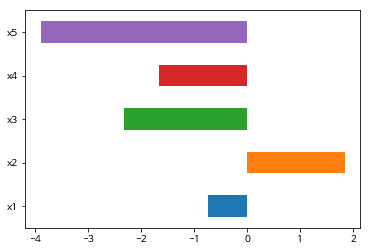

In [171]:
ds_reg_scaled_coef = pd.DataFrame({"Coef" : reg_multi_scaled_results.params.values[1:]},index=reg_multi_rfe_model.exog_names[1:])
ds_reg_scaled_coef.plot.barh(y="Coef",legend=False)

'\n#ds_house_x_const = ds_house.drop(["MEDV"],axis =1, inplace = False)\nds_house_x_scale = scale(ds_house_x_const)\n# 후진제거법에 의해 선택된 데이터에 상수 1 입력\nds_house_x_scale=sm.add_constant(ds_house_x_scale[selected_cols])\n#  회귀 모델 생성\nreg_multi_rfe_model = sm.OLS(ds_house_y,ds_house_x_scale)\n# 적합\nreg_multi_scaled_results = reg_multi_rfe_model.fit()\n# 설명변수 중요도\nds_reg_scaled_coef = pd.DataFrame({"Coef" : reg_multi_scaled_results.params.values[1:]},index=reg_multi_rfe_model.exog_names[1:])\nds_reg_scaled_coef.plot.barh(y="Coef",legend=False)\n'

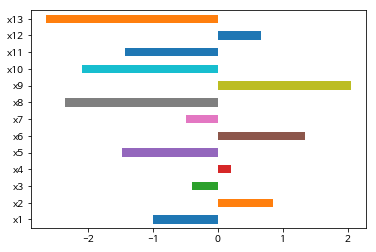

In [175]:
ds_house_x_scale=sm.add_constant(ds_house_x_scale)
reg_multi_rfe_model = sm.OLS(ds_house_y,ds_house_x_scale)
# 적합
reg_multi_scaled_results = reg_multi_rfe_model.fit()
ds_reg_scaled_coef = pd.DataFrame({"Coef" : reg_multi_scaled_results.params.values[1:]},index=reg_multi_rfe_model.exog_names[1:])
ds_reg_scaled_coef.plot.barh(y="Coef",legend=False)